# HiddenLayer Graph Demo - TensorFlow

In [1]:
import os
import tensorflow as tf
import tensorflow.contrib.slim.nets as nets
import hiddenlayer as hl
import hiddenlayer.transforms as ht

# Hide GPUs. Not needed for this demo.
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## VGG 16

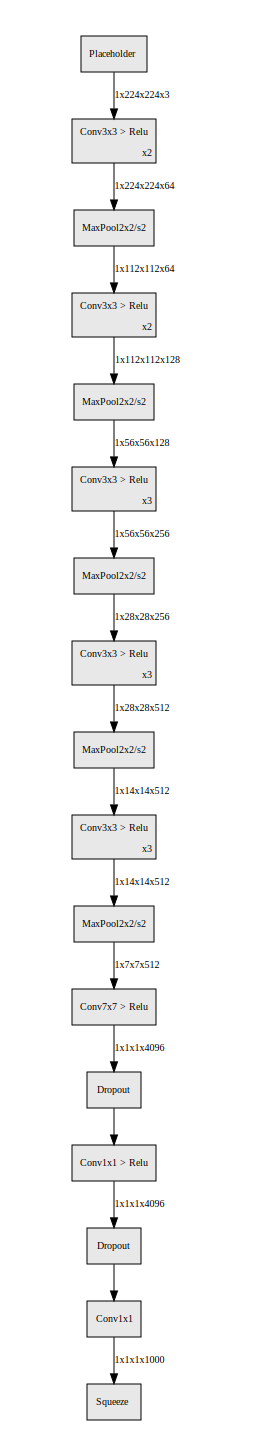

In [2]:
with tf.Session() as sess:
    with tf.Graph().as_default() as tf_graph:
        # Setup input placeholder
        inputs = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
        # Build model
        predictions, _ = nets.vgg.vgg_16(inputs)
        # Build HiddenLayer graph
        hl_graph = hl.build_graph(tf_graph)

# Display graph
# Jupyter Notebook renders it automatically
hl_graph

# Alexnet v2

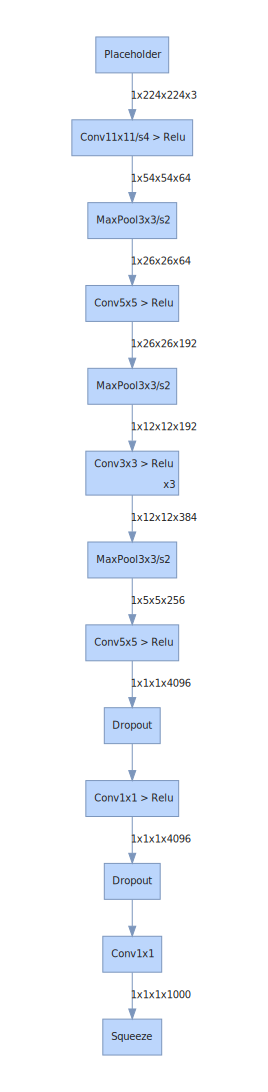

In [3]:
with tf.Session() as sess:
    with tf.Graph().as_default() as tf_graph:
        # Setup input placeholder
        inputs = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
        # Build model
        predictions, _ = nets.alexnet.alexnet_v2(inputs)
        # Build layout
        hl_graph = hl.build_graph(tf_graph)

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue

# Display
hl_graph

# Inception v1

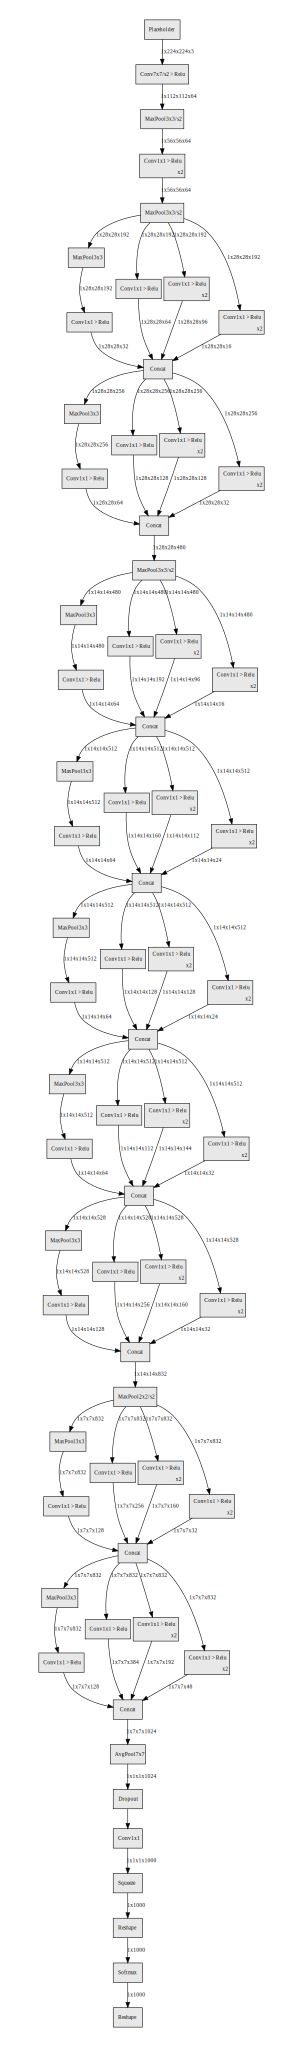

In [4]:
with tf.Session() as sess:
    with tf.Graph().as_default() as tf_graph:
        # Setup input placeholder
        inputs = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
        # Build model
        predictions, _ = nets.inception.inception_v1(inputs)
        # Build layout
        hl_graph = hl.build_graph(tf_graph)

# Display
hl_graph

## Transforms and Graph Expressions

A Graph Expression is like a Regular Expression for graphs. It simplifies searching for nodes that fit a particular pattern. For example, the graph expression `Conv > Relu` will find Conv layers that are followed by RELU layers. And the expressions `Conv | MaxPool` will match any Conv and MaxPool layers that are in parallel branches (i.e. have the same parent node). See examples of more complex graph expressions below.

Once the graph expression finds the nodes, we use Transforms to modify them. For example, if we want to delete all nodes of type `Const`, we'll use the transform `Prune("Const")`. The graph expression here is simple, `Const`, which matches any node with operation of type Const. And the Prune() transform deletes the node.

See more examples below. And, also, check `SIMPLICITY_TRANSFORMS` in `transforms.py`.

# Inception v1 with Simplified Inception Modules

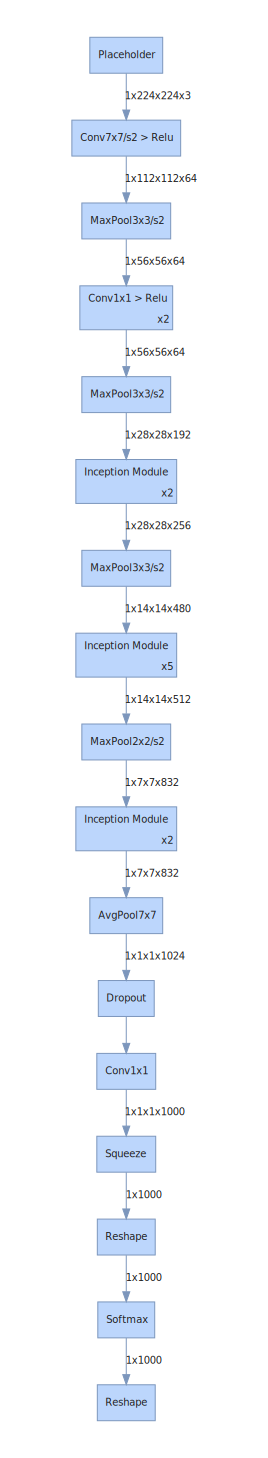

In [5]:
# Define custom transforms to replice the default ones
transforms = [
    # Fold inception blocks into one node
    ht.Fold("""
        ( (MaxPool > Conv > Relu) |
          (Conv > Relu > Conv > Relu) |
          (Conv > Relu > Conv > Relu) |
          (Conv > Relu)
        ) > Concat
        """, "Inception", "Inception Module"),
    # Fold Conv and Relu together if they come together
    ht.Fold("Conv > Relu", "ConvRelu"),
    # Fold repeated nodes
    ht.FoldDuplicates(),
]

with tf.Session() as sess:
    with tf.Graph().as_default() as tf_graph:
        # Setup input placeholder
        inputs = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
        # Build model
        predictions, _ = nets.inception.inception_v1(inputs)
        # Build layout
        hl_graph = hl.build_graph(tf_graph, transforms=transforms)

# Display
hl_graph.theme = hl.graph.THEMES["blue"].copy()
hl_graph

## ResNet v1 50

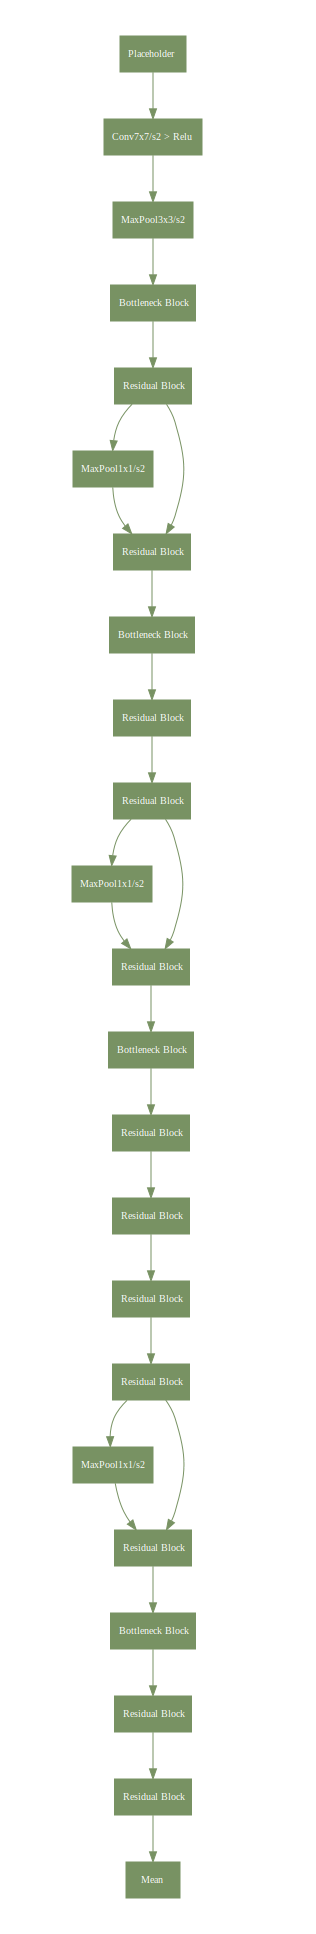

In [6]:
# Custom transforms to group nodes of residual and bottleneck blocks
transforms = [
    # Fold Pad into the Conv that follows it 
    ht.Fold("Pad > Conv", "__last__"),
    # Fold Conv/Relu
    ht.Fold("Conv > Relu", "ConvRelu"),
    # Fold bottleneck blocks
    hl.transforms.Fold("""
        ((ConvRelu > ConvRelu > Conv) | Conv) > Add > Relu
        """, "BottleneckBlock", "Bottleneck Block"),
    # Fold residual blocks
    hl.transforms.Fold("""ConvRelu > ConvRelu > Conv > Add > Relu""",
                       "ResBlock", "Residual Block"),
]

# Build TensorFlow graph
with tf.Session() as sess:
    with tf.Graph().as_default() as tf_graph:
        # Setup input placeholder
        inputs = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
        # Build model
        predictions, _ = nets.resnet_v1.resnet_v1_50(inputs)
        # Build HiddenLayer graph
        hl_graph = hl.build_graph(tf_graph, transforms=transforms)

# Customize the theme. The theme is a simple dict defined in graph.py
hl_graph.theme.update({
    "fill_color": "#789263",
    "outline_color": "#789263",
    "font_color": "#FFFFFF",
})

# Display
hl_graph

# Overfeat

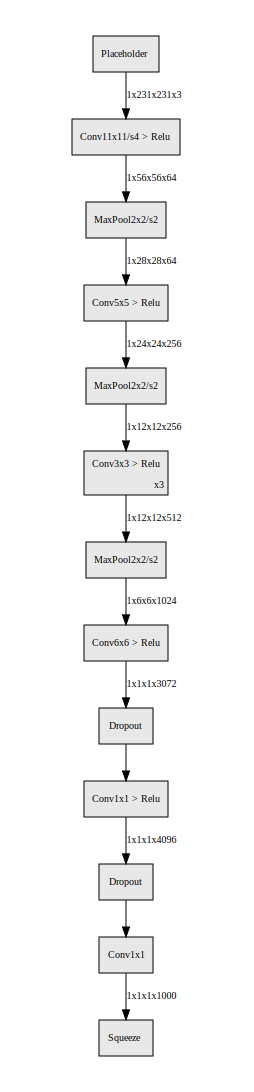

In [7]:
with tf.Session() as sess:
    with tf.Graph().as_default() as tf_graph:
        # Setup input placeholder
        inputs = tf.placeholder(tf.float32, shape=(1, 231, 231, 3))
        # Build model
        predictions, _ = nets.overfeat.overfeat(inputs)
        # Build layout
        hl_graph = hl.build_graph(tf_graph)

# Display
hl_graph